In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

class ImageDataLoader(Sequence):
    def __init__(self, input_dir, target_dir, filenames, batch_size, img_size=(300, 300)):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.filenames = filenames
        self.batch_size = batch_size
        self.img_size = img_size
    
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        x = []
        y = []
        for file_name in batch_x:
            input_img = cv2.imread(os.path.join(self.input_dir, file_name))
            input_img = cv2.resize(input_img, self.img_size) / 255.0
            
            target_img = cv2.imread(os.path.join(self.target_dir, file_name), cv2.IMREAD_GRAYSCALE)
            target_img = cv2.resize(target_img, self.img_size) / 255.0
            
            unique_values = np.unique(target_img)
            if not np.array_equal(unique_values, [0, 1]):
                _, target_img = cv2.threshold(target_img, 0.5, 1, cv2.THRESH_BINARY)
            
            target_img = np.expand_dims(target_img, axis=-1)
            
            x.append(input_img)
            y.append(target_img)
        
        return np.array(x), np.array(y)


In [3]:
# Custom metrics
def pixel_accuracy(y_true, y_pred):
    y_pred = K.round(y_pred)
    correct_pixels = K.sum(K.equal(y_true, y_pred))
    total_pixels = K.prod(K.shape(y_true))
    return correct_pixels / total_pixels

def iou(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / union

def dice_coef(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection) / (K.sum(y_true) + K.sum(y_pred))

def specificity(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / possible_negatives

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Combined loss
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
# from tensorflow.keras.layers import Conv2DTranspose

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# # tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
#     # U-Net model
#     def linknet_model(input_shape):
#         inputs = Input(input_shape)

#         # Encoder
#         c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#         p1 = MaxPooling2D((2, 2))(c1)

#         c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#         p2 = MaxPooling2D((2, 2))(c2)

#         c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
#         p3 = MaxPooling2D((2, 2))(c3)

#         # Decoder
#         u2 = UpSampling2D((2, 2))(p3)
#         u2 = Concatenate()([u2, c2])
#         d2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

#         u1 = UpSampling2D((2, 2))(d2)
#         u1 = Concatenate()([u1, c1])
#         d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

#         outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)

#         return Model(inputs, outputs)
#     model = linknet_model((300, 300, 3))
#     model.compile(optimizer='adam', loss=combined_loss, 
#                 metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

#     model.summary()

In [9]:
from tensorflow.keras.layers import add, multiply
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    
    # Upsample g to match the spatial dimensions of x
    g_up = UpSampling2D(size=(2, 2))(g)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(g_up)
    
    f = Activation('relu')(add([theta_x, phi_g]))
    
    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)
    
    att_x = multiply([x, rate])
    
    return att_x
def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def attention_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = conv_block(p2, 256)
    
    # Decoder with attention
    att1 = attention_block(c2, c3, 128)
    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, att1])
    d1 = conv_block(u1, 128)
    d1 = Add()([d1, c2])  # Residual connection
    
    att2 = attention_block(c1, d1, 64)
    u2 = UpSampling2D((2, 2))(d1)
    u2 = Concatenate()([u2, att2])
    d2 = conv_block(u2, 64)
    d2 = Add()([d2, c1])  # Residual connection
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d2)
    
    return Model(inputs, outputs)

model = attention_unet((300, 300, 3))
model.compile(optimizer='adam', loss=combined_loss, 
              metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 300, 300, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 300, 300, 64  256        ['conv2d_25[0][0]']              
 ormalization)                  )                                                             

In [10]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, multiply, add

# def attention_block(x, g, inter_channel):
#     theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    
#     # Upsample g to match the spatial dimensions of x
#     g_up = UpSampling2D(size=(2, 2))(g)
#     phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(g_up)
    
#     f = Activation('relu')(add([theta_x, phi_g]))
    
#     psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
#     rate = Activation('sigmoid')(psi_f)
    
#     att_x = multiply([x, rate])
    
#     return att_x


# def attention_unet(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     p1 = MaxPooling2D((2, 2))(c1)
    
#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#     p2 = MaxPooling2D((2, 2))(c2)
    
#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
#     # Decoder with attention
#     att1 = attention_block(c2, c3, 128)
#     u1 = UpSampling2D((2, 2))(c3)
#     u1 = Concatenate()([u1, att1])
#     d1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    
#     att2 = attention_block(c1, d1, 64)
#     u2 = UpSampling2D((2, 2))(d1)
#     u2 = Concatenate()([u2, att2])
#     d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(d2)
    
#     return Model(inputs, outputs)
# model = attention_unet((300, 300, 3))
# model.compile(optimizer='adam', loss=combined_loss, 
#           metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

# model.summary()

In [ ]:
# from tensorflow.keras.layers import Conv2DTranspose

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# # tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
#     # U-Net model
#     def unet_model(input_shape):
#         inputs = Input(input_shape)
#         c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#         p1 = MaxPooling2D((2, 2))(c1)
#         c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
#         p2 = MaxPooling2D((2, 2))(c2)
#         c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

#         # Use Conv2DTranspose for upsampling
#         u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
#         u2 = Concatenate()([u2, c2])
#         c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

#         # Use Conv2DTranspose for upsampling
#         u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
#         u1 = Concatenate()([u1, c1])
#         outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

#         return Model(inputs, outputs)
#     model = unet_model((300, 300, 3))
#     model.compile(optimizer='adam', loss=combined_loss, 
#               metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

#     model.summary()

In [ ]:
# model = unet_model((300, 300, 3))
# model.compile(optimizer='adam', loss=combined_loss, 
#               metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

# model.summary()

In [33]:
# # Create a new instance of ImageDataLoader
# input_dir = '/kaggle/input/anemic-rbc-dataset/Anemic_RBC_dataset_exe/AneRBC-II/Original_images/healthy/'
# target_dir= '/kaggle/input/anemic-rbc-dataset/Anemic_RBC_dataset_exe/AneRBC-II/Binary_segmented/healthy/'


# all_image_filenames = os.listdir(input_dir)
# train_filenames, val_filenames = train_test_split(all_image_filenames, test_size=0.2, random_state=42)


In [12]:
import os
import shutil

# Define source and destination directories
src_dir_original = "/kaggle/input/anemic-rbc-dataset/Anemic_RBC_dataset_exe/AneRBC-I/Original_Images/healthy/"
dest_dir_original = "/kaggle/working/Original_Images_healthy/"

src_dir_segmented = "/kaggle/input/anemic-rbc-dataset/Anemic_RBC_dataset_exe/AneRBC-I/Binary_Segmented/healthy/"
dest_dir_segmented = "/kaggle/working/Binary_Segmented_healthy/"

# Create destination directories if they don't exist
os.makedirs(dest_dir_original, exist_ok=True)
os.makedirs(dest_dir_segmented, exist_ok=True)

# Copy images to writable directories
for file_name in os.listdir(src_dir_original):
    shutil.copy(os.path.join(src_dir_original, file_name), dest_dir_original)

for file_name in os.listdir(src_dir_segmented):
    shutil.copy(os.path.join(src_dir_segmented, file_name), dest_dir_segmented)

# Apply mogrify command on copied images
!mogrify -strip {dest_dir_original}*.png
!mogrify -strip {dest_dir_segmented}*.png


In [13]:
# Create a new instance of ImageDataLoader
input_dir = '/kaggle/working/Original_Images_healthy/'
target_dir= '/kaggle/working/Binary_Segmented_healthy/'


all_image_filenames = os.listdir(input_dir)
train_filenames, val_filenames = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

In [ ]:
batch_size = 16

train_data_loader = ImageDataLoader(input_dir, target_dir, train_filenames, batch_size)
val_data_loader = ImageDataLoader(input_dir, target_dir, val_filenames, batch_size)

history = model.fit(train_data_loader, validation_data=val_data_loader, epochs=200)

Epoch 1/200
100/100 [==============================] - 88s 799ms/step - loss: 0.1363 - accuracy: 0.9611 - dice_coef: 0.9687 - iou: 0.9395 - precision: 0.9703 - recall: 0.9671 - specificity: 0.9515 - val_loss: 7.1021 - val_accuracy: 0.3805 - val_dice_coef: 1.9536e-04 - val_iou: 9.7691e-05 - val_precision: 0.9701 - val_recall: 9.7557e-05 - val_specificity: 1.0000
Epoch 2/200


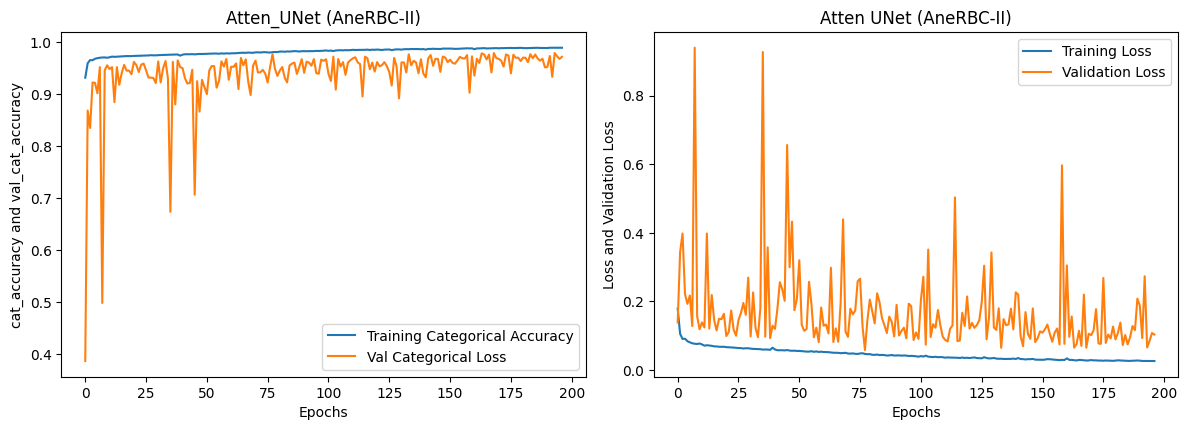

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/atten-unet-ane-rbc2/training_Atten_Unet_RBC.csv')  # Replace 'path_to_your_csv_file.csv' with the path to your CSV file

# Create a dictionary to simulate the 'history.history' structure
history = {
    'categorical_accuracy': df['categorical_accuracy'].tolist(),
    'val_categorical_accuracy': df['val_categorical_accuracy'].tolist(),
    'loss': df['loss'].tolist(),
    'val_loss': df['val_loss'].tolist(),
    'iou': df['iou'].tolist(),
    'val_iou': df['val_iou'].tolist(),
    'precision': df['precision'].tolist(),
    'val_recall': df['val_recall'].tolist()
}

plt.figure(figsize=(12, 8))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('Atten_UNet (AneRBC-II)')
plt.ylabel('cat_accuracy and val_cat_accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Categorical Accuracy', 'Val Categorical Loss'], loc='lower right')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Atten UNet (AneRBC-II)')
plt.ylabel('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.tight_layout()
save_path = "/kaggle/working/Atten_Unet_Training_AneRBC2.png"
plt.savefig(save_path, dpi=300)
plt.show()


